### 준비할 데이터셋 ###
  
1) plant1_train 공장 데이터(훈련시에만 사용 <- tem_in_loc1,2,3 / hum_in_loc1,2,3)  
2) 기상 데이터( 서산 ASOS 데이터셋 <- 날씨마루에서 다운받을수 있음)

https://bd.kma.go.kr/kma2019/svc/intro/serviceInfo2.do?pageNum=5&menuCd=F030103000

In [1]:
import pandas as pd
from numpy import mean
from scipy import stats #scipy란 과학기술 통계분석함수 모음이다.
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False
import mglearn 
import missingno as msno
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Dense,Activation,LSTM,Dropout
from keras.optimizers import Adam
from IPython .display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from numpy import argmax

Using TensorFlow backend.


In [84]:
#plant1_train_with_weather는 서산 ASOS의 데이터셋과 plant1의 데이터셋을 '일시'에 맞춰서 동일한 '일시'일 경우 merge한 결과이다.
datanew=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_train_with_weather.csv')

In [85]:
del datanew['Unnamed: 0']

In [86]:
datanew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54803 entries, 0 to 54802
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   일시             54803 non-null  object 
 1   tem_in_loc1    54803 non-null  float64
 2   hum_in_loc1    54803 non-null  float64
 3   tem_coil_loc1  54803 non-null  float64
 4   tem_in_loc2    54803 non-null  float64
 5   hum_in_loc2    54803 non-null  float64
 6   tem_coil_loc2  54803 non-null  float64
 7   tem_in_loc3    54803 non-null  float64
 8   hum_in_loc3    54803 non-null  float64
 9   tem_coil_loc3  54803 non-null  float64
 10  tem_out_loc1   54803 non-null  float64
 11  hum_out_loc1   54803 non-null  float64
 12  cond_loc1      54803 non-null  float64
 13  cond_loc2      54803 non-null  float64
 14  cond_loc3      54803 non-null  float64
 15  기온(°C)         54803 non-null  float64
 16  누적강수량(mm)      54803 non-null  float64
 17  풍향(deg)        54803 non-null  float64
 18  풍속(m/s

In [87]:
datanew['일시'] = pd.to_datetime(datanew['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [ ]:
#우린 기상데이터 : 기온(°C),누적강수량(mm),습도(%),일사(MJ/m^2),일조(Sec) 총 5개를 사용해서
#plant1의 loc1(보관장소1)의 습도를 예측하는 모델을 생성 할것이다.

datanew=datanew[['기온(°C)','누적강수량(mm)','습도(%)','일사(MJ/m^2)','일조(Sec)','hum_in_loc1']]
datanew

NameError: name 'datanewori' is not defined

In [89]:
#이미 전처리는 완료했지만 설마모르니 결측치 제거
datanew=datanew.dropna(axis=0)

In [90]:
#dataframe의 모든 데이터들을 각 컬럼마다 정규화하는 함수
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

#https://blog.naver.com/PostView.nhn?blogId=gudrb1707&logNo=221275862122 참조함

In [91]:
datanew=MinMaxScaler(datanew)

In [92]:
result=[]
for i in range(datanew.shape[0]):
    result.append(datanew.iloc[i,:].values) #행 데이터들을 묶음으로 리스트에 저장해줌
print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [93]:
result=np.array(result)

In [94]:
result

array([[0.621881  , 0.        , 0.97472527, 0.        , 0.        ,
        0.66931964],
       [0.71401151, 0.        , 0.97472527, 0.        , 0.        ,
        0.66379974],
       [0.71785029, 0.        , 0.97472527, 0.        , 0.        ,
        0.61489088],
       ...,
       [0.34740883, 0.        , 0.55274725, 0.49810141, 0.68156425,
        0.32451861],
       [0.33205374, 0.        , 0.56373626, 0.49810141, 0.68156425,
        0.33504493],
       [0.3243762 , 0.        , 0.58901099, 0.49810141, 0.68156425,
        0.34454429]])

In [95]:
#데이터 나누기
row = int(round(result.shape[0]*0.9))
result.shape
#7가지 특성 : 기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1
row #테스트용 데이터 갯수

49323

In [96]:
#랜덤결과 일정하게 하기 위해서 seed 설정
np.random.seed(0)

In [97]:
#랜덤결과 일정하게 하기 위해서 seed 설정
np.random.seed(0)


In [98]:
np.random.shuffle(train)
#훈련용 데이터셋 설정

In [99]:
# 훈련용 데이터/라벨 데이터셋 분류
x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

In [100]:
# 테스트용 데이터/라벨 데이터셋 분류
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]

In [101]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((43842, 5, 1), (5480, 5, 1), (43842,), (5480,))

In [102]:
#딥러닝을 위한 모델 생성(이때는 습도를 측정하는 것이므로 LSTM을 사용한다.)
# step 3. 모델생성
model = Sequential()
model.add(LSTM(64, input_shape=(5,1), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.7))
model.add(Dense(1, activation='tanh'))
model.compile('adam', 'mean_squared_error',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5, 64)             16896     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [104]:
hist=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50)

Train on 43842 samples, validate on 5480 samples
Epoch 1/50
43842/43842 [==============================] - 2s 53us/step - loss: 0.0289 - accuracy: 4.5618e-05 - val_loss: 0.0151 - val_accuracy: 0.0000e+00
Epoch 2/50
43842/43842 [==============================] - 2s 50us/step - loss: 0.0227 - accuracy: 4.5618e-05 - val_loss: 0.0140 - val_accuracy: 0.0000e+00
Epoch 3/50
43842/43842 [==============================] - 2s 50us/step - loss: 0.0182 - accuracy: 2.2809e-05 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 4/50
43842/43842 [==============================] - 2s 50us/step - loss: 0.0134 - accuracy: 4.5618e-05 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 5/50
43842/43842 [==============================] - 2s 50us/step - loss: 0.0130 - accuracy: 4.5618e-05 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 6/50
43842/43842 [==============================] - 2s 50us/step - loss: 0.0127 - accuracy: 4.5618e-05 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 7/50
43842/4384

In [105]:
#훈련된 모델로 예측한 예측값 pred
pred = model.predict(x_test)
data_standadized_np = (pred - mean(pred,)) / (pred)

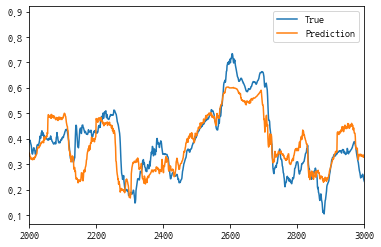

In [106]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test*datanew['hum_in_loc1'].max(), label='True')
ax.plot(pred*datanew['hum_in_loc1'].max(), label='Prediction')
ax.legend()
plt.xlim(2000,3000)
plt.show()

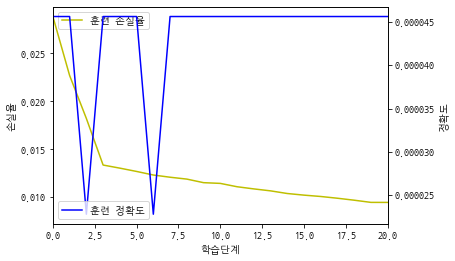

In [107]:
# step7. 모델학습 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='훈련 손실율')
acc_ax.plot(hist.history['accuracy'],'b',label='훈련 정확도')

loss_ax.set_xlabel("학습단계")
loss_ax.set_ylabel("손실율")
acc_ax.set_ylabel("정확도")

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.xlim(0,20)

plt.show()